In [1]:
#!/usr/bin/env python

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import tensorflow as tf

from edward.models import Dirichlet, Normal, InverseGamma, Categorical
from edward.util import get_dims, log_sum_exp, get_session

plt.style.use('ggplot')

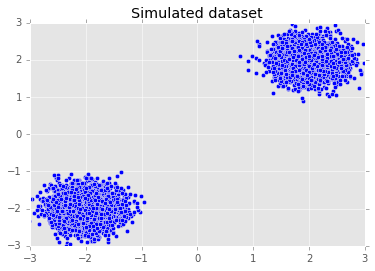

In [2]:
N = 5000
M = 100 
K = 2                  
D = 2                              
N_ITER = 1000
N_SAMPLES = 10


def build_toy_dataset(N):
    pi = np.array([0.5, 0.5])
    mus = [[2, 2], [-2, -2]]
    stds = [[0.1, 0.1], [0.1, 0.1]]
    x = np.zeros((N, 2), dtype=np.float32)
    for n in range(N):
        k = np.argmax(np.random.multinomial(1, pi))
        x[n, :] = np.random.multivariate_normal(mus[k], np.diag(stds[k]))
    return x

def next_batch(M):
    idx_batch = np.random.choice(N, M)
    return x_data[idx_batch, :], idx_batch


ed.set_seed(42)
x_data = build_toy_dataset(N)

plt.scatter(x_data[:, 0], x_data[:, 1])
plt.axis([-3, 3, -3, 3])
plt.title('Simulated dataset')
plt.show()

In [3]:
# Probabilistic model definition
pi = Dirichlet(alpha=tf.constant([1.0]*K))
mu = Normal(mu=tf.zeros([K, D]), sigma=tf.ones([K, D]))
sigma = InverseGamma(alpha=tf.ones([K, D]), beta=tf.ones([K, D]))
c = Categorical(logits=ed.tile(ed.logit(pi), [M, 1]))
x = Normal(mu=tf.gather(mu, c), sigma=tf.gather(sigma, c))

In [4]:
# Variational model definition
var_qpi_alpha = tf.Variable(tf.random_normal([K]))
var_qmu_sigma = tf.Variable(tf.random_normal([K, D]))
var_qsigma_alpha = tf.Variable(tf.random_normal([K, D]))
var_qsigma_beta = tf.Variable(tf.random_normal([K, D]))

qpi_alpha = tf.nn.softplus(var_qpi_alpha)
qc_logits = tf.Variable(tf.zeros([N, K]))
qmu_mu = tf.Variable(tf.random_normal([K, D]))
qmu_sigma = tf.nn.softplus(var_qmu_sigma)
qsigma_alpha = tf.nn.softplus(var_qsigma_alpha)
qsigma_beta = tf.nn.softplus(var_qsigma_beta)

idx_ph = tf.placeholder(tf.int32, M)

qpi = Dirichlet(alpha=qpi_alpha)
qc = Categorical(logits=tf.gather(qc_logits, idx_ph))
qmu = Normal(mu=qmu_mu, sigma=qmu_sigma)
qsigma = InverseGamma(alpha=qsigma_alpha, beta=qsigma_beta)

x_ph = tf.placeholder(tf.float32, [M, D])

In [5]:
# Inference process
inference_global = ed.KLqp({pi: qpi, mu: qmu, sigma: qsigma}, data={x: x_ph, c: qc})
inference_local = ed.KLqp({c: qc}, data={x: x_ph, pi: qpi, mu: qmu, sigma: qsigma})

inference_global.initialize(scale={x: float(N) / M, c: float(N) / M}, var_list=[var_qpi_alpha, qmu_mu, var_qmu_sigma, var_qsigma_alpha, var_qsigma_beta], n_samples=N_SAMPLES)
inference_local.initialize(scale={x: float(N) / M, c: float(N) / M}, var_list=[qc_logits], n_samples=N_SAMPLES)

In [18]:
sess = ed.get_session()
#init = tf.initialize_all_variables()
init = tf.global_variables_initializer()
init.run()

for t in range(N_ITER):
    x_batch, idx_batch = next_batch(M)
    for _ in range(5):
        inference_local.update(feed_dict={x_ph: x_batch, idx_ph: idx_batch})
    info_dict = inference_global.update(feed_dict={x_ph: x_batch, idx_ph: idx_batch})
    inference_global.print_progress(info_dict)

Iteration    1 [  0%]: Loss = 2753549.500
Iteration  100 [ 10%]: Loss = 68543.148
Iteration  200 [ 20%]: Loss = 52379.145
Iteration  300 [ 30%]: Loss = 61754.039
Iteration  400 [ 40%]: Loss = 130347.891
Iteration  500 [ 50%]: Loss = 46282.219
Iteration  600 [ 60%]: Loss = 45676.547
Iteration  700 [ 70%]: Loss = 50253.895
Iteration  800 [ 80%]: Loss = 42092.551
Iteration  900 [ 90%]: Loss = 58615.488
Iteration 1000 [100%]: Loss = 43071.180


In [42]:
# Criticism
nsamples = 20
clusters_sample = np.zeros((5000,nsamples))
# this is definitely not the smart way to do this
for n in range(nsamples):
    clusters = np.array([])
    for i in range(50):
        clusters = np.r_[clusters,sess.run(qc.sample(), feed_dict={idx_ph: np.arange(i*100,(i+1)*100)})]
    clusters_sample[:,n] = clusters

In [54]:
majority_vote_clusters = (clusters_sample.sum(1) > 10).astype(np.int)

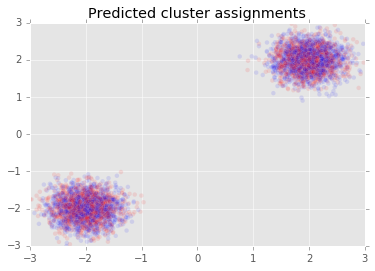

In [55]:
plt.scatter(x_data[:, 0], x_data[:, 1], c=majority_vote_clusters, cmap=cm.bwr, alpha=.1)
plt.axis([-3, 3, -3, 3])
plt.title('Predicted cluster assignments')
plt.show()